## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

In [2]:
df_train = pd.read_csv("train_dataset_train.csv")
df_sample_solution = pd.read_csv("sample_solution.csv")

df_named = pd.read_csv("named.csv")
df_type_contract = pd.read_csv("type_contract.csv")
df_log = pd.read_csv("log.csv")

## Рассмотрим датасет по ближе

In [3]:
df_train.head(3)

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  5992 non-null   int64
 1   blocked      5992 non-null   int64
dtypes: int64(2)
memory usage: 93.8 KB


In [5]:
df_named.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   date         object
 1   url          object
 2   contract_id  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ MB


In [6]:
df_type_contract.head(3)

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0


In [7]:
df_log.head()

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах


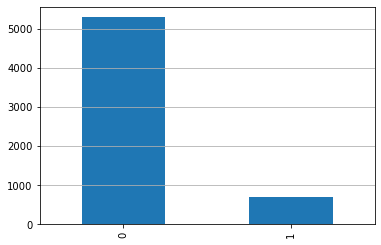

In [8]:
#Посмотрим на распределение целевой переменной
df_train['blocked'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

**из графика мы видим, что в представленном датасете существует большой дисбаланс классов целевой переменной, учтем это при построении модели**

In [9]:
#оставим для даты день, месяц и год обращения
df_log['event_date'] = pd.to_datetime(df_log['event_date'])
df_log['event_date'] = df_log['event_date'].dt.strftime('%y-%m-%d')
df_log.head()

,contract_id,event_date,event_type
0,36294,21-03-28,Добавление в Обращались с номеров
1,36294,21-03-28,Обращение в службу заботы о клиентах
2,36294,21-03-28,Выключение IPTV-пакета
3,36294,21-03-28,Включение IPTV-пакета
4,36294,21-03-28,Обращение в службу заботы о клиентах


In [10]:
#выделим в отдельные датафреймы наиболее важные обращения
df_log3 = df_log.query('event_type == "Обращение в службу заботы о клиентах"')
df_log4 = df_log.query('event_type == "Включена 20% скидка"')
df_log5 = df_log.query('event_type == "Возвращение клиента"')
df_log6 = df_log.query('event_type == "Изменение схемы оплаты"')
df_log7 = df_log.query('event_type == "Предложение ТВ-пакета"')

In [11]:
#df_log.info()

In [12]:
#найдем время первого и последнего обращения для каждого клиента
df_log_time_max = df_log.groupby("contract_id")['event_date'].max()
df_log_time_min = df_log.groupby("contract_id")['event_date'].min()

In [13]:
df_named['date'] = pd.to_datetime(df_named['date'])

In [14]:
%%time
df_named['date'] = df_named['date'].dt.strftime('%y-%m-%d')
df_named['date'].head(3)

Wall time: 2min 2s


0    21-04-17
1    21-04-17
2    21-04-17
Name: date, dtype: object

In [15]:
#найдем время первого и последнего обращения к конкурентам
df_named_max = df_named.groupby("contract_id")['date'].max()
df_named_min = df_named.groupby("contract_id")['date'].min()

Узнаем размерность наборов

In [16]:
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_sample_solution", df_sample_solution.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)

df_train (5992, 2)
df_named (10646537, 3)
df_sample_solution (810, 2)
df_type_contract (6805, 2)
df_log (25274, 3)


### Видоизмение данных

Обьединим два набора с данными

In [17]:
df_train = pd.merge(df_train, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id")

df_train.head(3)

,contract_id,blocked,day_or_month_contract
0,7780,0,0.0
1,7785,0,0.0
2,7794,0,0.0


Text(0.5, 1.0, 'Распределение предсказываемой величены')

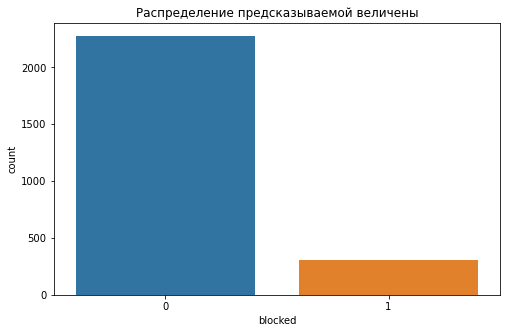

In [18]:
#посмотрим на распределение целевой переменной в зависимости от вида контракта
plt.rcParams['figure.figsize'] = 8, 5
sns.countplot(x = "blocked" , data  = df_train.query('day_or_month_contract == 1.0')).set_title('Распределение предсказываемой величены')

Добавим столбец - колличество обращений человека

In [19]:
count_log = df_log.groupby("contract_id").count()

count_log.head(3)

,event_date,event_type
contract_id,,
3453,1,1
3454,1,1
3456,4,4


In [20]:
df_train = pd.merge(df_train, count_log , on="contract_id", how='left').drop(["event_type"],axis =1)

In [21]:
df_train.head(3)

,contract_id,blocked,day_or_month_contract,event_date
0,7780,0,0.0,9.0
1,7785,0,0.0,1.0
2,7794,0,0.0,NaN


In [22]:
df_train.rename(columns={'event_date': 'коичество обращений'}, inplace=True)

добавим количество обращений к конкурентам

In [23]:
count_competitors = df_named.groupby("contract_id").count()

count_competitors.head(3)

,date,url
contract_id,,
3455,24,24
3458,1,1
3459,2,2


In [24]:
df_train = pd.merge(df_train, count_competitors , on="contract_id", how='left').drop(["date"],axis =1)
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url
0,7780,0,0.0,9.0,83.0
1,7785,0,0.0,1.0,10.0
2,7794,0,0.0,NaN,NaN


Добавим количество некоторых типов типов обращений

In [25]:
count_event = df_log3.groupby("contract_id")['event_type'].count()
count_event4 = df_log4.groupby("contract_id")['event_type'].count()
count_event5 = df_log5.groupby("contract_id")['event_type'].count()
count_event6 = df_log6.groupby("contract_id")['event_type'].count()
count_event7 = df_log7.groupby("contract_id")['event_type'].count()

In [26]:
df_train = pd.merge(df_train, count_event, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,event_type
0,7780,0,0.0,9.0,83.0,3.0
1,7785,0,0.0,1.0,10.0,NaN
2,7794,0,0.0,NaN,NaN,NaN


In [27]:
df_train.rename(columns={'event_type': 'обращение в службу заботы'}, inplace=True)

In [28]:
df_train = pd.merge(df_train, count_event4, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,event_type
0,7780,0,0.0,9.0,83.0,3.0,NaN
1,7785,0,0.0,1.0,10.0,NaN,NaN
2,7794,0,0.0,NaN,NaN,NaN,NaN


In [29]:
df_train.rename(columns={'event_type': 'Включена_20%_скидка'}, inplace=True)

In [30]:
df_train = pd.merge(df_train, count_event5, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,event_type
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN


In [31]:
df_train.rename(columns={'event_type': 'Возвращение_клиента'}, inplace=True)

In [32]:
df_train = pd.merge(df_train, count_event6, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,event_type
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_train.rename(columns={'event_type': 'Изменение_схемы_оплаты'}, inplace=True)

In [34]:
df_train = pd.merge(df_train, count_event7, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,event_type
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN,NaN
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_train.rename(columns={'event_type': 'Предложение_ТВ_пакета'}, inplace=True)

In [36]:
#сгруппируем обращения по каждому клиенту
event_types = df_log.groupby("contract_id")['event_type'].apply(lambda tags: ','.join(tags))

In [37]:
df_train = pd.merge(df_train, event_types, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,event_type
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN,NaN,"Отключение услуги Автоплатёж,Обращение в служб..."
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,Реестр договоров
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_train.rename(columns={'event_type': 'тип обращений'}, inplace=True)

In [39]:
#сгруппируем даты обращений по каждому клинту
event_dates = df_log.groupby("contract_id")['event_date'].apply(lambda tags: ','.join(tags))
event_dates

contract_id
3453                                               21-03-03
3454                                               21-04-28
3456                    21-03-21,21-03-21,21-03-21,21-03-21
3457                    21-03-09,21-03-10,21-03-13,21-04-29
3458      21-03-01,21-03-04,21-03-07,21-03-10,21-03-13,2...
                                ...                        
274601    21-04-20,21-04-20,21-04-20,21-04-20,21-04-20,2...
274710    21-04-20,21-04-20,21-04-20,21-04-20,21-04-20,2...
274782    21-04-15,21-04-17,21-04-19,21-04-19,21-04-22,2...
274786    21-04-15,21-04-25,21-04-26,21-04-28,21-04-28,2...
274918                                             21-04-15
Name: event_date, Length: 4311, dtype: object

In [40]:
df_train = pd.merge(df_train, event_dates, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,event_date
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN,NaN,"Отключение услуги Автоплатёж,Обращение в служб...","21-03-17,21-03-17,21-04-01,21-04-01,21-04-01,2..."
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,Реестр договоров,21-03-30
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_train.rename(columns={'event_date': 'даты_обращений'}, inplace=True)

добавим в датафрейм первые и последние даты обращения к конкурентам и в техподдержку

In [42]:
df_train = pd.merge(df_train, df_log_time_max, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,event_date
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN,NaN,"Отключение услуги Автоплатёж,Обращение в служб...","21-03-17,21-03-17,21-04-01,21-04-01,21-04-01,2...",21-04-28
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,Реестр договоров,21-03-30,21-03-30
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_train.rename(columns={'event_date': 'df_log_time_max'}, inplace=True)

In [44]:
df_train = pd.merge(df_train, df_log_time_min, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,event_date
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN,NaN,"Отключение услуги Автоплатёж,Обращение в служб...","21-03-17,21-03-17,21-04-01,21-04-01,21-04-01,2...",21-04-28,21-03-17
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,Реестр договоров,21-03-30,21-03-30,21-03-30
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df_train.rename(columns={'event_date': 'df_log_time_min'}, inplace=True)

In [46]:
df_train = pd.merge(df_train, df_named_max, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,df_log_time_min,date
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN,NaN,"Отключение услуги Автоплатёж,Обращение в служб...","21-03-17,21-03-17,21-04-01,21-04-01,21-04-01,2...",21-04-28,21-03-17,21-04-29
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,Реестр договоров,21-03-30,21-03-30,21-03-30,21-04-22
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_train.rename(columns={'date': 'df_named_max'}, inplace=True)

In [48]:
df_train = pd.merge(df_train, df_named_min, on="contract_id", how='left')
df_train.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,df_log_time_min,df_named_max,date
0,7780,0,0.0,9.0,83.0,3.0,NaN,NaN,NaN,NaN,"Отключение услуги Автоплатёж,Обращение в служб...","21-03-17,21-03-17,21-04-01,21-04-01,21-04-01,2...",21-04-28,21-03-17,21-04-29,21-04-28
1,7785,0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,Реестр договоров,21-03-30,21-03-30,21-03-30,21-04-22,21-04-03
2,7794,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_train.rename(columns={'date': 'df_named_min'}, inplace=True)

In [50]:
len(df_train)

5992

Заменим пропуски на нули

In [51]:
df_train = df_train.fillna(0)

Добавим количество дней между первым и последним оращением, а также между обращением в служьу поддержки и к конкурентам

In [52]:
df_train['1'] = (pd.to_datetime(df_train['df_named_max'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_train['df_named_min'], format='%y-%m-%d', errors='coerce'))
df_train['2'] = (pd.to_datetime(df_train['df_log_time_max'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_train['df_log_time_min'], format='%y-%m-%d', errors='coerce'))

In [53]:
df_train['1'] = df_train['1'].dt.days

In [54]:
df_train['2'] = df_train['2'].dt.days

In [55]:
df_train['3'] = (pd.to_datetime(df_train['df_log_time_max'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_train['df_named_max'], format='%y-%m-%d', errors='coerce'))
df_train['4'] = (pd.to_datetime(df_train['df_log_time_min'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_train['df_named_min'], format='%y-%m-%d', errors='coerce'))

In [56]:
df_train['3'] = df_train['3'].dt.days
df_train['4'] = df_train['4'].dt.days

In [57]:
df_train.head()

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,df_log_time_min,df_named_max,df_named_min,1,2,3,4
0,7780,0,0.0,9.0,83.0,3.0,0.0,0.0,0.0,0.0,"Отключение услуги Автоплатёж,Обращение в служб...","21-03-17,21-03-17,21-04-01,21-04-01,21-04-01,2...",21-04-28,21-03-17,21-04-29,21-04-28,1.0,42.0,-1.0,-42.0
1,7785,0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,Реестр договоров,21-03-30,21-03-30,21-03-30,21-04-22,21-04-03,19.0,0.0,-23.0,-4.0
2,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,7795,0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,"Информер ВК. Показ,Включение интернета на 20 м...","21-03-08,21-03-08,21-03-08,21-03-18,21-03-20,2...",21-03-24,21-03-08,0,0,NaN,16.0,NaN,NaN
4,7798,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,"Информер ВК. Показ,Информер ВК. Показ,Информер...","21-03-13,21-03-13,21-04-17",21-04-17,21-03-13,0,0,NaN,35.0,NaN,NaN


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 5991
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   contract_id                5992 non-null   int64  
 1   blocked                    5992 non-null   int64  
 2   day_or_month_contract      5992 non-null   float64
 3   коичество обращений        5992 non-null   float64
 4   url                        5992 non-null   float64
 5   обращение в службу заботы  5992 non-null   float64
 6   Включена_20%_скидка        5992 non-null   float64
 7   Возвращение_клиента        5992 non-null   float64
 8   Изменение_схемы_оплаты     5992 non-null   float64
 9   Предложение_ТВ_пакета      5992 non-null   float64
 10  тип обращений              5992 non-null   object 
 11  даты_обращений             5992 non-null   object 
 12  df_log_time_max            5992 non-null   object 
 13  df_log_time_min            5992 non-null   objec

посмотрим на распределение величин

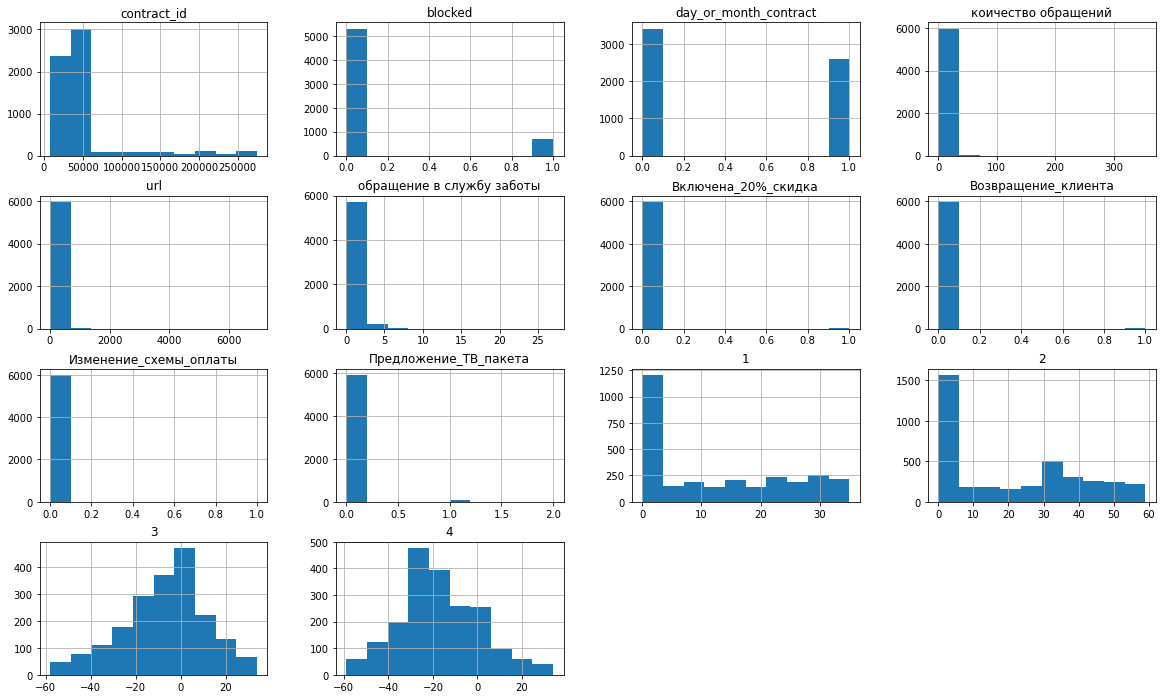

In [59]:
_ = df_train[df_train.columns].hist(figsize=(20,12))

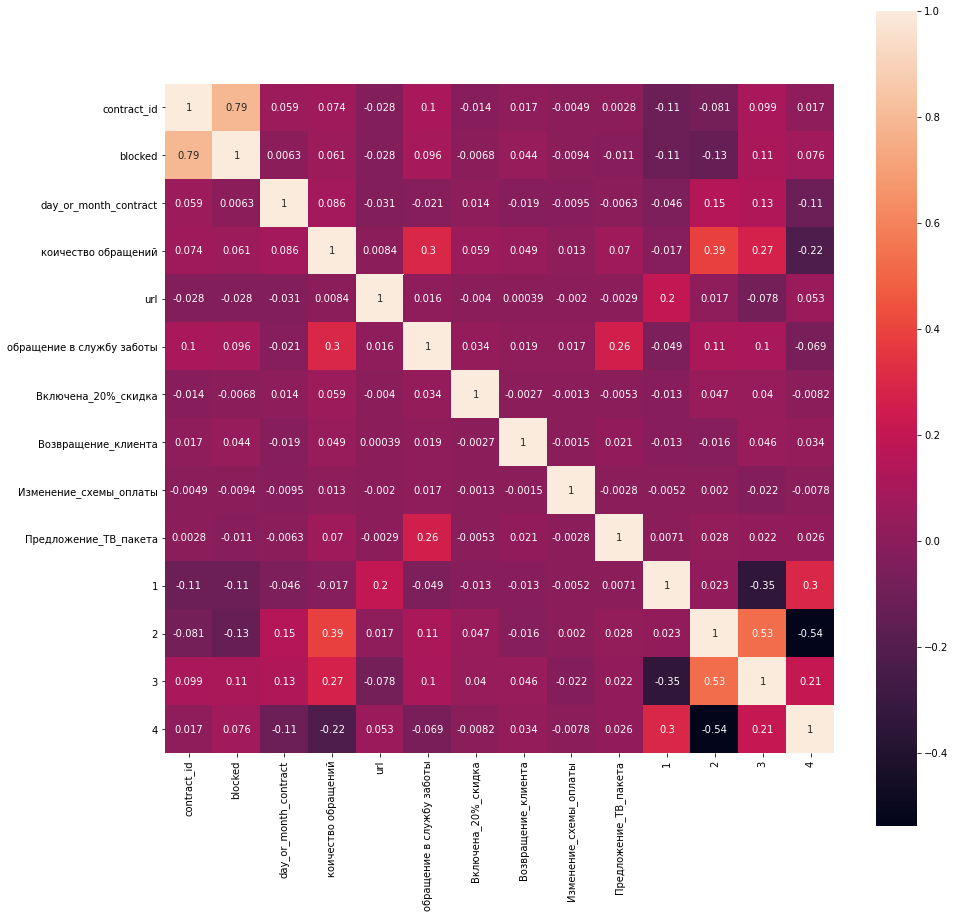

In [60]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [61]:
cat_features = df_train.dtypes[df_train.dtypes == "object"].index.values
cat_features

array(['тип обращений', 'даты_обращений', 'df_log_time_max',
       'df_log_time_min', 'df_named_max', 'df_named_min'], dtype=object)

In [62]:
X = df_train.drop(["contract_id", "blocked"], axis = 1)
y = df_train[["blocked"]]

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 5991
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day_or_month_contract      5992 non-null   float64
 1   коичество обращений        5992 non-null   float64
 2   url                        5992 non-null   float64
 3   обращение в службу заботы  5992 non-null   float64
 4   Включена_20%_скидка        5992 non-null   float64
 5   Возвращение_клиента        5992 non-null   float64
 6   Изменение_схемы_оплаты     5992 non-null   float64
 7   Предложение_ТВ_пакета      5992 non-null   float64
 8   тип обращений              5992 non-null   object 
 9   даты_обращений             5992 non-null   object 
 10  df_log_time_max            5992 non-null   object 
 11  df_log_time_min            5992 non-null   object 
 12  df_named_max               5992 non-null   object 
 13  df_named_min               5992 non-null   objec

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify = y)

In [65]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify = y_test)

## Обучение модели

### Catboost

In [66]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train),
y=y_train.values.reshape(-1))
class_weights = dict(zip(classes, weights))


from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=600, verbose = 100, class_weights=class_weights)
clf.fit(X_train, y_train, cat_features = cat_features, eval_set=(X_val, y_val), plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.054284
0:	learn: 0.6823739	test: 0.6851769	best: 0.6851769 (0)	total: 440ms	remaining: 4m 23s
100:	learn: 0.4807463	test: 0.5891444	best: 0.5874197 (73)	total: 5.09s	remaining: 25.2s
200:	learn: 0.4181920	test: 0.6067456	best: 0.5848985 (144)	total: 9.55s	remaining: 19s
300:	learn: 0.3722987	test: 0.6312916	best: 0.5848985 (144)	total: 13.9s	remaining: 13.8s
400:	learn: 0.3420084	test: 0.6605833	best: 0.5848985 (144)	total: 18.2s	remaining: 9.05s
500:	learn: 0.3187509	test: 0.6828101	best: 0.5848985 (144)	total: 22.5s	remaining: 4.46s
599:	learn: 0.2977037	test: 0.7202843	best: 0.5848985 (144)	total: 28s	remaining: 0us

bestTest = 0.5848984681
bestIteration = 144

Shrink model to first 145 iterations.


посмотрим основные параметры модели

In [67]:
for key,value in clf.get_all_params().items():
    print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, Logloss
combinations_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations, 600
sampling_frequency, PerTree
fold_permutation_block, 0
leaf_estimation_method, Newton
counter_calc_method, SkipTest
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
ctr_leaf_count_limit, 18446744073709551615
bayesian_matrix_reg, 0.10000000149011612
one_hot_max_size, 2
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, False
max_ctr_complexity, 4
model_size_reg, 0.5
simple_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options, {'tags': {}

## Оценка точности

In [68]:
pred = clf.predict(X_test)

In [69]:
y_test.head(3)

,blocked
4331,0
721,0
711,0


In [70]:
from sklearn.metrics import recall_score

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.7249055712936733


посмотрим на важность признаков

In [71]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,df_named_max,15.552735
1,df_log_time_max,11.799225
2,1,11.460490
3,df_named_min,11.194986
4,2,10.286212
5,тип обращений,9.836056
6,url,7.252899
7,df_log_time_min,6.705281
8,4,4.037219
9,3,3.829104


## Создание файла с ответом

In [72]:
df_sample = pd.merge(df_sample_solution, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id")

df_sample.head(3)

,contract_id,blocked,day_or_month_contract
0,3453,0,0
1,3454,0,1
2,3455,0,1


In [73]:
df_sample = pd.merge(df_sample, count_log , on="contract_id", how='left').drop(["event_type"],axis =1)
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,event_date
0,3453,0,0,1.0
1,3454,0,1,1.0
2,3455,0,1,NaN


In [74]:
df_sample.rename(columns={'event_date': 'коичество обращений'}, inplace=True)

In [75]:
df_sample = pd.merge(df_sample, count_competitors , on="contract_id", how='left').drop(["date"],axis =1)
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url
0,3453,0,0,1.0,NaN
1,3454,0,1,1.0,NaN
2,3455,0,1,NaN,24.0


In [76]:
df_sample = pd.merge(df_sample, count_event, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,event_type
0,3453,0,0,1.0,NaN,NaN
1,3454,0,1,1.0,NaN,NaN
2,3455,0,1,NaN,24.0,NaN


In [77]:
df_sample.rename(columns={'event_type': 'обращение в службу заботы'}, inplace=True)

In [78]:
df_sample = pd.merge(df_sample, count_event4, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,event_type
0,3453,0,0,1.0,NaN,NaN,NaN
1,3454,0,1,1.0,NaN,NaN,NaN
2,3455,0,1,NaN,24.0,NaN,NaN


In [79]:
df_sample.rename(columns={'event_type': 'Включена_20%_скидка'}, inplace=True)

In [80]:
df_sample = pd.merge(df_sample, count_event5, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,event_type
0,3453,0,0,1.0,NaN,NaN,NaN,NaN
1,3454,0,1,1.0,NaN,NaN,NaN,NaN
2,3455,0,1,NaN,24.0,NaN,NaN,NaN


In [81]:
df_sample.rename(columns={'event_type': 'Возвращение_клиента'}, inplace=True)

In [82]:
df_sample = pd.merge(df_sample, count_event6, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,event_type
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN


In [83]:
df_sample.rename(columns={'event_type': 'Изменение_схемы_оплаты'}, inplace=True)

In [84]:
df_sample = pd.merge(df_sample, count_event7, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,event_type
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN,NaN


In [85]:
df_sample.rename(columns={'event_type': 'Предложение_ТВ_пакета'}, inplace=True)

In [86]:
df_sample = pd.merge(df_sample, event_types, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,event_type
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Информер ВК. Показ
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Внутреннее сообщение
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df_sample.rename(columns={'event_type': 'тип обращений'}, inplace=True)

In [88]:
df_sample = pd.merge(df_sample, event_dates, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,event_date
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Информер ВК. Показ,21-03-03
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Внутреннее сообщение,21-04-28
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
df_sample.rename(columns={'event_date': 'даты_обращений'}, inplace=True)

In [90]:
df_sample = pd.merge(df_sample, df_log_time_max, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,event_date
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Информер ВК. Показ,21-03-03,21-03-03
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Внутреннее сообщение,21-04-28,21-04-28
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
df_sample.rename(columns={'event_date': 'df_log_time_max'}, inplace=True)

In [92]:
df_sample = pd.merge(df_sample, df_log_time_min, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,event_date
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Информер ВК. Показ,21-03-03,21-03-03,21-03-03
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Внутреннее сообщение,21-04-28,21-04-28,21-04-28
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df_sample.rename(columns={'event_date': 'df_log_time_min'}, inplace=True)

In [94]:
df_sample = pd.merge(df_sample, df_named_max, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,df_log_time_min,date
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Информер ВК. Показ,21-03-03,21-03-03,21-03-03,NaN
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Внутреннее сообщение,21-04-28,21-04-28,21-04-28,NaN
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21-04-28


In [95]:
df_sample.rename(columns={'date': 'df_named_max'}, inplace=True)

In [96]:
df_sample = pd.merge(df_sample, df_named_min, on="contract_id", how='left')
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,df_log_time_min,df_named_max,date
0,3453,0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Информер ВК. Показ,21-03-03,21-03-03,21-03-03,NaN,NaN
1,3454,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Внутреннее сообщение,21-04-28,21-04-28,21-04-28,NaN,NaN
2,3455,0,1,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21-04-28,21-04-01


In [97]:
df_sample.rename(columns={'date': 'df_named_min'}, inplace=True)

In [98]:
df_sample = df_sample.fillna(0)

In [99]:
df_sample['1'] = (pd.to_datetime(df_sample['df_named_max'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_sample['df_named_min'], format='%y-%m-%d', errors='coerce'))
df_sample['2'] = (pd.to_datetime(df_sample['df_log_time_max'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_sample['df_log_time_min'], format='%y-%m-%d', errors='coerce'))

In [100]:
df_sample['1'] = df_sample['1'].dt.days
df_sample['2'] = df_sample['2'].dt.days

In [101]:
df_sample['3'] = (pd.to_datetime(df_sample['df_log_time_max'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_sample['df_named_max'], format='%y-%m-%d', errors='coerce'))
df_sample['4'] = (pd.to_datetime(df_sample['df_log_time_min'], format='%y-%m-%d', errors='coerce') - pd.to_datetime(df_sample['df_named_min'], format='%y-%m-%d', errors='coerce'))

In [102]:
df_sample['3'] = df_sample['3'].dt.days
df_sample['4'] = df_sample['4'].dt.days

In [103]:
df_sample.head(3)

,contract_id,blocked,day_or_month_contract,коичество обращений,url,обращение в службу заботы,Включена_20%_скидка,Возвращение_клиента,Изменение_схемы_оплаты,Предложение_ТВ_пакета,тип обращений,даты_обращений,df_log_time_max,df_log_time_min,df_named_max,df_named_min,1,2,3,4
0,3453,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Информер ВК. Показ,21-03-03,21-03-03,21-03-03,0,0,NaN,0.0,NaN,NaN
1,3454,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Внутреннее сообщение,21-04-28,21-04-28,21-04-28,0,0,NaN,0.0,NaN,NaN
2,3455,0,1,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,21-04-28,21-04-01,27.0,NaN,NaN,NaN


In [104]:
X_test_sample = df_sample.drop(["contract_id", "blocked"], axis = 1)

In [105]:
pred = clf.predict(X_test_sample)

In [106]:
df_sample_solution['blocked'] = pred

In [107]:
df_sample_solution['blocked'].value_counts()

0    603
1    207
Name: blocked, dtype: int64

In [108]:
df_sample_solution.head()

,contract_id,blocked
0,3453,1
1,3454,0
2,3455,0
3,3456,1
4,3457,0


In [109]:
df_sample_solution.set_index('contract_id', inplace = True)

In [110]:
df_sample_solution.to_csv("sample_submission1.csv")